# 6. Reconciled Probabilistic Forecasts (PERM-BU)

<a href="https://colab.research.google.com/github/Nixtla/hierarchicalforecast/blob/main/nbs/examples/PERMBU_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we will explore probabilistic hierarchical sample reconciliation using the PERM-BU method. The PERM-BU (Taieb et. al, 2017) method leverages empirical bottom-level marginal distributions with empirical copula functions (describing bottom-level dependencies) to generate the distribution of the aggregate-level distributions using the bottom-up reconciliation. The sample reordering technique from the PERM-BU method reinjects multivariate dependencies into independent bottom-level samples.

## Installing/Importing Libraries

In [1]:
%%capture
!pip install hierarchicalforecast
!pip install numba statsforecast

In [2]:
import inspect
import numpy as np
import pandas as pd

In [3]:
from statsforecast.core import StatsForecast
from statsforecast.models import AutoARIMA, ETS, Naive

from hierarchicalforecast.utils import aggregate
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.methods import PERMBU, BottomUp, MinTrace

import matplotlib.pyplot as plt

## Reading Hierarchical Dataset

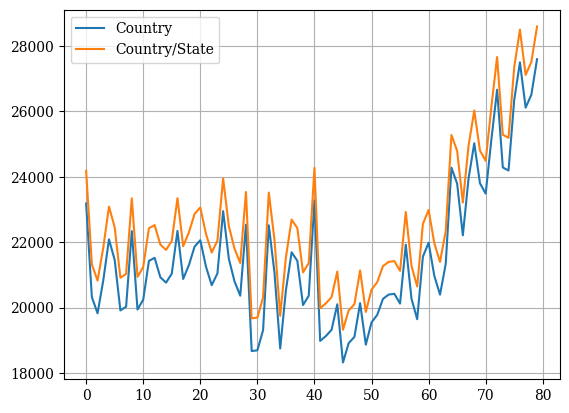

In [4]:
# Load TourismSmall dataset
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/tourism.csv')
df = df.rename({'Trips': 'y', 'Quarter': 'ds'}, axis=1)
df.insert(0, 'Country', 'Australia')

# Create hierarchical seires based on geographic levels and purpose
# And Convert quarterly ds string to pd.datetime format
hierarchy_levels = [['Country'],
                    ['Country', 'State'], 
                    ['Country', 'Purpose'], 
                    ['Country', 'State', 'Region'], 
                    ['Country', 'State', 'Purpose'], 
                    ['Country', 'State', 'Region', 'Purpose']]

Y_df, S, tags = aggregate(df=df, spec=hierarchy_levels)
qs = Y_df['ds'].str.replace(r'(\d+) (Q\d)', r'\1-\2', regex=True)
Y_df['ds'] = pd.PeriodIndex(qs, freq='Q').to_timestamp()
Y_df = Y_df.reset_index()

#-----------------------------------------------------------------------------#
# Filter Australian States for small hierarchy structure
filter_tags = tags['Country/State/Region']
df = Y_df[Y_df['unique_id'].isin(filter_tags)].copy()
df.insert(0, 'Country', 'Australia')
df['State'] = df['unique_id'].apply(lambda x: x.split('/')[1]).copy()
df['Region'] = df['unique_id'].apply(lambda x: x.split('/')[2]).copy()
del df['unique_id']

hierarchy_levels = [['Country'], 
                    ['Country', 'State'],
                    ['Country', 'State', 'Region']]
Y_df, S, tags = aggregate(df=df, spec=hierarchy_levels)
Y_df = Y_df.reset_index()
Y_df.unique_id = Y_df.unique_id.astype('category')
Y_df.unique_id = Y_df.unique_id.cat.set_categories(S.index) # Extra careful!!!

# Check dataset
y_country = Y_df[Y_df.unique_id=='Australia'].y
y_states = Y_df[Y_df['unique_id'].isin(tags['Country/State'])].y.values
y_states = y_states.reshape(8, len(y_country))
y_states = np.sum(y_states, axis=0)

plt.plot(y_country, label='Country')
plt.plot(y_states+1000, label='Country/State')
plt.legend()
plt.grid()
plt.show()

# Split train/test sets
Y_test_df  = Y_df.groupby('unique_id').tail(4)
Y_train_df = Y_df.drop(Y_test_df.index)

## StatsForecast Base Predictions

In [5]:
h = 4

n_series = len(Y_train_df.unique_id.unique())
n_time   = len(Y_train_df.ds.unique())

unique_ids = S.index
n_samples = n_time

In [6]:
# Declare StatsForecast model
fcst = StatsForecast(df=Y_train_df,
                     #models=[Naive()],
                     models=[AutoARIMA(season_length=4)],
                     freq='QS', n_jobs=-1)
model_name = fcst.models[0].__class__.__name__

# Insample Predictions
_ = fcst.forecast(h=h, fitted=True) # store insample forecasts
insample_fcsts_df = fcst.forecast_fitted_values().reset_index()
y_insample = insample_fcsts_df['y'].values.reshape(n_series, n_time)
y_hat_insample = insample_fcsts_df[model_name].values.reshape(n_series, n_time)

# Outsample Prediction Distribution
# Hacked normal variance from P(mu-1std<x<mu+1std) = 68.27
fcsts_df = fcst.forecast(h=h, level=[68.27])
fcsts_df['std'] = fcsts_df[f'{model_name}-hi-68.27'] - fcsts_df[model_name]

y_hat_mean = fcsts_df[model_name].values.reshape(n_series, h)
y_hat_std = fcsts_df['std'].values.reshape(n_series, h)

print('y_mean.shape', y_hat_mean.shape)
print('y_std.shape', y_hat_std.shape)
print('y_insample.shape', y_insample.shape)
print('y_hat_insample.shape', y_hat_insample.shape)

y_mean.shape (85, 4)
y_std.shape (85, 4)
y_insample.shape (85, 76)
y_hat_insample.shape (85, 76)


In [7]:
# Checking ordering of unique_id index
fcsts_df.head(12)

,ds,AutoARIMA,AutoARIMA-lo-68.27,AutoARIMA-hi-68.27,std
unique_id,,,,,
Australia,2017-01-01,27327.978516,26413.298828,28242.658203,914.679688
Australia,2017-04-01,25876.921875,24851.800781,26902.041016,1025.119141
Australia,2017-07-01,25447.902344,24323.132812,26572.671875,1124.769531
Australia,2017-10-01,26804.197266,25587.916016,28020.478516,1216.281250
Australia/ACT,2017-01-01,602.063660,537.789062,666.338318,64.274658
Australia/ACT,2017-04-01,602.063660,536.364075,667.763306,65.699646
Australia/ACT,2017-07-01,602.063660,534.969360,669.157959,67.094299
Australia/ACT,2017-10-01,602.063660,533.603088,670.524292,68.460632
Australia/New South Wales,2017-01-01,8358.686523,8031.725586,8685.646484,326.959961


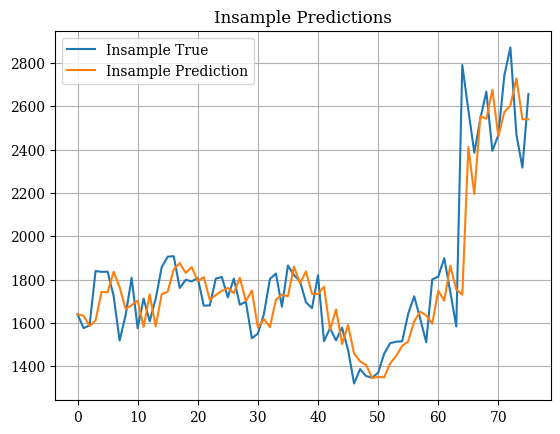

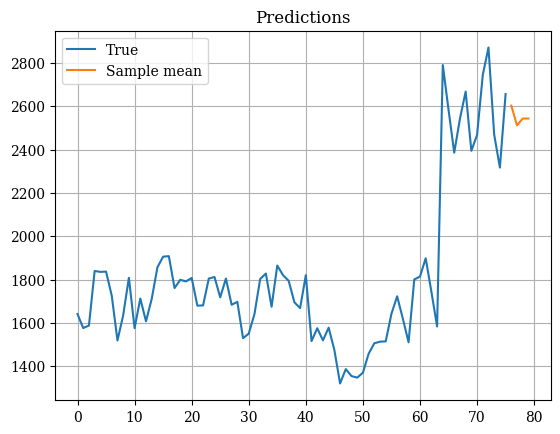

In [8]:
idx = 8

# Create plot vectors
empty = np.empty((n_series, n_time))
empty[:] = np.nan
y_hat_prediction = np.concatenate([empty, y_hat_mean], axis=1)

# Validate insample predictions
plt.plot(y_insample[idx,:], label='Insample True')
plt.plot(y_hat_insample[idx,:], label='Insample Prediction')
plt.title('Insample Predictions')
plt.legend()
plt.grid()
plt.show()

# Validate median sample predictions (Try reducing sample variance)
plt.plot(y_insample[idx,:], label='True')
plt.plot(y_hat_prediction[idx,:], label='Sample mean')
plt.title('Predictions')
plt.legend()
plt.grid()
plt.show()

## PERMBU Probabilistic Reconciliation

In [9]:
hrec = PERMBU()
hier_samples = hrec.reconcile(S=S.values,
                              y_insample=y_insample,
                              y_hat_insample=y_hat_insample,
                              y_hat_mean=y_hat_mean,
                              y_hat_std=y_hat_std)

hier_quantiles = np.quantile(hier_samples, q=[0.05, 0.5, 0.95], axis=2)
hier_quantiles = np.transpose(hier_quantiles, (1,2,0))

# Create plot vectors
empty_q = np.empty((n_series, n_time, 3))
empty_q[:] = np.nan
hier_quantiles = np.concatenate([empty_q, hier_quantiles], axis=1)
y_plot = Y_df.y.values
y_plot = y_plot.reshape(n_series,n_time+h)

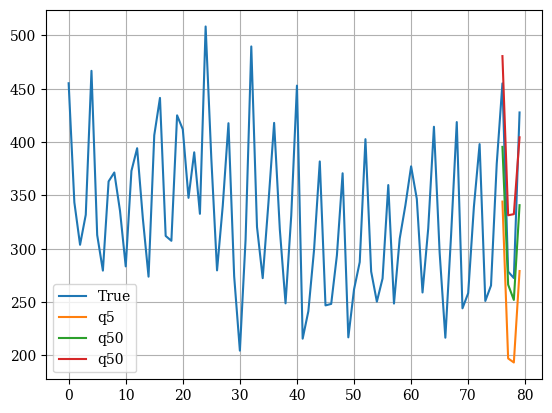

In [10]:
idx = 12

plt.plot(y_plot[idx,:], label='True')
plt.plot(hier_quantiles[idx, :, 0], label='q5')
plt.plot(hier_quantiles[idx, :, 1], label='q50')
plt.plot(hier_quantiles[idx, :, 2], label='q50')

plt.legend()
plt.grid()
plt.show()

### References
- [Taieb, Souhaib Ben and Taylor, James W and Hyndman, Rob J. (2017). Coherent probabilistic forecasts for hierarchical time series. International conference on machine learning ICML.](https://proceedings.mlr.press/v70/taieb17a.html)